DIY COVID-19 Dashboard

This notebook builds a small COVID-19 dashboard using data from the UK Health Security Agency (UKHSA).

I loaded daily COVID-19  cases, hospital admissions and deaths for England from JSON files (previously downloaded via the UKHSA API).
I wrangled these series into a single time-series table ('timeseriesdf').
Then, I produced basic visualisations of key trends.
And finally, I added simple interactive controls (using 'interact') to explore the data.

1. Setup and data loading 

In this section I import the Python libraries used in the project and load the three JSON files:
- daily cases
- hospital admissions
- deaths 

for England. These files were created in a previous notebook using the UKHSA API and saved locally.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("cases.json", "rt") as INFILE:
    cases=json.load(INFILE)
with open("deaths.json", "rt") as INFILE:
    deaths=json.load(INFILE)

In [3]:
len(cases), len(admissions), len(deaths)

(2128, 1916, 1444)

2. Data wrangling

Here I combine the three separate JSON datasets into a single Pandas DataFrame called 'timeseriesdf'.

Each row corresponds to a date, and the columns store the values for:

- 'cases'
- 'admissions'
- 'deaths'

This makes it much easier to slice the data by time and plot all metrics together.

In [4]:
data={}
for dataset in [admissions, cases, deaths]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value

In [5]:
len(data)

2128

In [6]:
data['2020-01-30']

{'COVID-19_cases_casesByDay': 1.0, 'COVID-19_deaths_ONSByDay': 1.0}

In [7]:
dates=list(data.keys())
dates.sort()
dates

['2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-

In [8]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

2020-01-30 00:00:00  to  2025-11-26 00:00:00


In [9]:
index=pd.date_range(startdate, enddate, freq='D')
timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'admissions', 'deaths'])
timeseriesdf

,cases,admissions,deaths
2020-01-30,NaN,NaN,NaN
2020-01-31,NaN,NaN,NaN
2020-02-01,NaN,NaN,NaN
2020-02-02,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN
...,...,...,...
2025-11-22,NaN,NaN,NaN
2025-11-23,NaN,NaN,NaN
2025-11-24,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN


In [10]:
# translate the columns to our metrics
metrics ={'cases': 'COVID-19_cases_casesByDay',
          'admissions': 'COVID-19_healthcare_admissionByDay',
          'deaths': 'COVID-19_deaths_ONSByDay'}

for date, entry in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for column in ['cases', 'admissions', 'deaths']: 
        metric_name=metrics[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(metric_name, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)
            
timeseriesdf

,cases,admissions,deaths
2020-01-30,1.0,0.0,1.0
2020-01-31,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0
2020-02-02,1.0,0.0,1.0
2020-02-03,18.0,0.0,0.0
...,...,...,...
2025-11-22,73.0,0.0,0.0
2025-11-23,69.0,0.0,0.0
2025-11-24,86.0,0.0,0.0
2025-11-25,68.0,0.0,0.0


3. Visualisation 

In this section I focus on two different metrics:

1. Daily COVID-19 cases in England
2. Daily COVID-19 deaths in England

This allows me to compare how the evolution of infections and fatalities differ over time. (Additional combined plots and log-scale views could be explored, but the two main graphs below are based on different metrics.)

I will also have an extra view to show the log-scale plot of cases, admissions and deaths in England.

Text(0, 0.5, 'Number of cases')

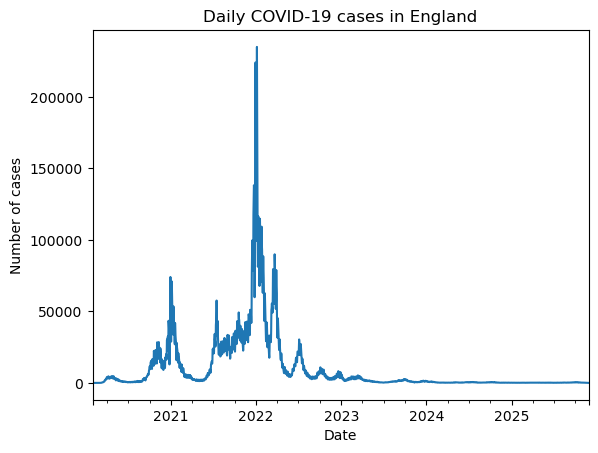

In [11]:
# Graph 1: daily cases in England
ax=timeseriesdf["cases"].plot() 
ax.set_title("Daily COVID-19 cases in England")
ax.set_xlabel("Date")
ax.set_ylabel("Number of cases")

Text(0, 0.5, 'Number of deaths')

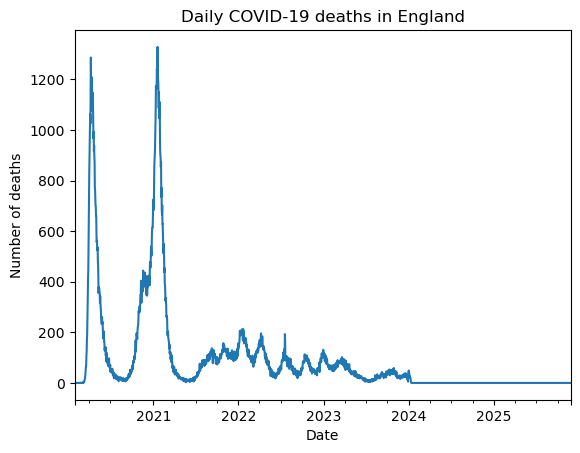

In [12]:
# Graph 2: daily deaths in England.
ax = timeseriesdf["deaths"].plot()
ax.set_title("Daily COVID-19 deaths in England")
ax.set_xlabel("Date")
ax.set_ylabel("Number of deaths")

Text(0, 0.5, 'Log(counts)')

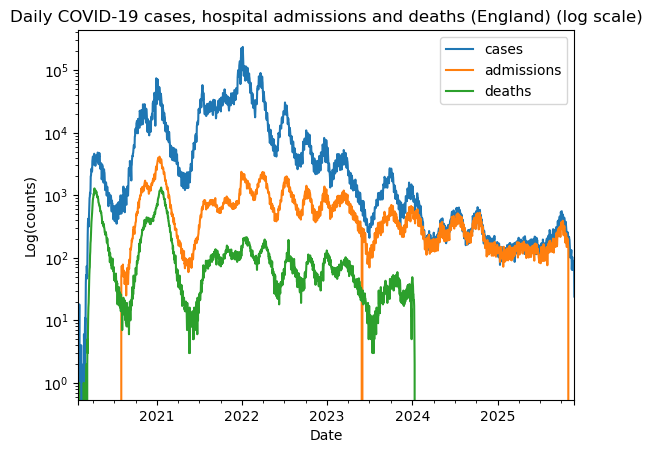

In [13]:
# Extra View: combined plot of cases, admissions and deaths (log scale)
ax=timeseriesdf.plot(logy=True) 
ax.set_title('Daily COVID-19 cases, hospital admissions and deaths (England) (log scale)')
ax.set_xlabel("Date")
ax.set_ylabel("Log(counts)")

In [14]:
timeseriesdf.head()      # first few rows
timeseriesdf.tail()      # last few rows
timeseriesdf.describe()  # basic stats for each column

,cases,admissions,deaths
count,2128.0,2128.0,2128.0
unique,1636.0,1002.0,363.0
top,0.0,0.0,0.0
freq,12.0,212.0,716.0


4. (Later) Interactivity

Finally, I add interactive controls using 'interact' from 'ipywidgets'.

The 'covid_dashboard' function plots a selected metric (cases, admissions, or deaths) and lets the user choose:

- whether to use a log scale on the y-axis
- a start and end year for the plot 

There is also a small "refresh" button which reloads the JSON files and rebuilds the time-series table, in case the data files are updated.

This turns the notebook into a simple interactive dashboard for exploring the data.

In [15]:
def refresh_data():
    """
    Reload the JSON files and rebuild timeseriesdf.
    Useful if the data files have been updated.
    """
    global cases, admissions, deaths, data, timeseriesdf

    # 1. Reload JSON files
    with open("cases.json", "rt") as f:
        cases = json.load(f)
    with open("admissions.json", "rt") as f:
        admissions = json.load(f)
    with open("deaths.json", "rt") as f:
        deaths = json.load(f)

    # 2. Rebuild the 'data' dictionary (same pattern as before)
    data = {}
    for dataset in [cases, admissions, deaths]:
        for entry in dataset:
            date = entry["date"]
            metric_name = entry["metric"]
            value = entry["metric_value"]

            if date not in data:
                data[date] = {}
            data[date][metric_name] = value

    # 3. Rebuild the timeseriesdf (same logic as in Section 2)
    dates = sorted(data.keys())
    startdate = parse_date(dates[0])
    enddate   = parse_date(dates[-1])

    index = pd.date_range(startdate, enddate, freq="D")
    timeseriesdf = pd.DataFrame(index=index,
                                columns=["cases", "admissions", "deaths"])

    metrics = {
        "cases": "COVID-19_cases_casesByDay",
        "admissions": "COVID-19_healthcare_admissionByDay",
        "deaths": "COVID-19_deaths_ONSByDay",
    }

    for date, entry in data.items():
        pd_date = parse_date(date)
        for column in ["cases", "admissions", "deaths"]:
            metric_name = metrics[column]
            value = entry.get(metric_name, 0.0)
            timeseriesdf.loc[pd_date, column] = value

    timeseriesdf.fillna(0.0, inplace=True)


In [16]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [17]:
from ipywidgets import interact, Button

In [18]:
def covid_dashboard(metric="cases",
                    logy=False,
                    start_year=2020,
                    end_year=2023):
    """
    Simple interactive dashboard:
    - choose metric (cases/admissions/deaths)
    - choose log scale on/off
    - choose start/end year
    """

    # Make a copy so we don't accidentally modify the original
    df = timeseriesdf.copy()

    # Filter by year range
    df = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

    # Safety check: if no data after filtering, just return
    if df.empty:
        print("No data for this period.")
        return

    # Plot the selected metric
    ax = df[metric].plot(logy=logy)

    ax.set_title(f"Daily COVID-19 {metric} in England")
    ax.set_xlabel("Date")
    ylabel = "Number of people"
    if logy:
        ylabel += " (log scale)"
    ax.set_ylabel(ylabel)

    plt.show()

In [19]:
min_year = int(timeseriesdf.index.year.min())
max_year = int(timeseriesdf.index.year.max())

interact(
    covid_dashboard,
    metric=["cases", "admissions", "deaths"],
    logy=False,
    start_year=(min_year, max_year),
    end_year=(min_year, max_year),
)

interactive(children=(Dropdown(description='metric', options=('cases', 'admissions', 'deaths'), value='cases')…

<function __main__.covid_dashboard(metric='cases', logy=False, start_year=2020, end_year=2023)>

The "Refresh data' button below reloads the JSON files and rebuilds 'timeseriesdf'.

This would be useful if the underlying data files were updated without changing the rest of the notebook.

In [20]:
refresh_button = Button(
    description="Refresh data",
    tooltip="Reload JSON files and update the dataset",
)

def on_refresh_clicked(b):
    refresh_data()
    print("Data refreshed.")

refresh_button.on_click(on_refresh_clicked)

refresh_button

Button(description='Refresh data', style=ButtonStyle(), tooltip='Reload JSON files and update the dataset')

Reflections 

Working with the UKHSA API and JSON data was new to me, and I initially found the paging and data wrangling challenging.

Restructuring the raw lists of dictionaries into a single time-series DataFrame helped me to understand how to prepare data for plotting.

If I had more time, I would extend the dashboard to compare different regions or add controls for selecting shorter date ranges and additional metrics.